# Tutorial JP225
We show how to train DeepScalper on JP225 15min trading.

## Step 1: Import Packages
Modify the system path and load the corresponding packages and functions 

In [1]:
import os
import sys

import warnings
warnings.filterwarnings("ignore")

ROOT = os.path.dirname(os.path.abspath("."))
sys.path.append(ROOT)

import torch
import argparse
import os.path as osp
from mmcv import Config
from trademaster.utils import replace_cfg_vals
from trademaster.nets.builder import build_net
from trademaster.environments.builder import build_environment
from trademaster.datasets.builder import build_dataset
from trademaster.agents.builder import build_agent
from trademaster.optimizers.builder import build_optimizer
from trademaster.losses.builder import build_loss
from trademaster.trainers.builder import build_trainer
from trademaster.transition.builder import build_transition
from trademaster.utils import plot
from trademaster.utils import set_seed
set_seed(2024)

No CUDA runtime is found, using CUDA_HOME='/home/pi/miniconda3/envs/TradeMaster'


E0324 11:54:20.199908200    7521 socket_utils_common_posix.cc:223] check for SO_REUSEPORT: {"created":"@1711248860.199886600","description":"Protocol not available","errno":92,"file":"external/com_github_grpc_grpc/src/core/lib/iomgr/socket_utils_common_posix.cc","file_line":202,"os_error":"Protocol not available","syscall":"getsockopt(SO_REUSEPORT)"}


## Step 2: Load Configs
Load default config from the file `configs/algorithmic_trading/algorithmic_trading_JP225_deepscalper_deepscalper_adam_mse.py`

In [2]:

parser = argparse.ArgumentParser(description='Download Alpaca Datasets')
parser.add_argument("--config", default=osp.join(ROOT, "configs", "algorithmic_trading", "algorithmic_trading_JP225_deepscalper_deepscalper_adam_mse.py"),
                    help="download datasets config file path")
parser.add_argument("--task_name", type=str, default="train")
args, _= parser.parse_known_args()

cfg = Config.fromfile(args.config)
task_name = args.task_name
cfg = replace_cfg_vals(cfg)

In [3]:
cfg

Config (path: /home/pi/workspace/fm/TradeMaster/configs/algorithmic_trading/algorithmic_trading_JP225_deepscalper_deepscalper_adam_mse.py): {'data': {'type': 'AlgorithmicTradingDataset', 'data_path': 'data/algorithmic_trading/JP225', 'train_path': 'data/algorithmic_trading/JP225/train.csv', 'valid_path': 'data/algorithmic_trading/JP225/valid.csv', 'test_path': 'data/algorithmic_trading/JP225/test.csv', 'test_dynamic_path': 'data/algorithmic_trading/JP225/Market_Dynamics_Model/JP225/test_labeled_slice_and_merge_model_3dynamics_minlength12_quantile_labeling.csv', 'tech_indicator_list': ['high', 'low', 'open', 'close', 'adjcp', 'zopen', 'zhigh', 'zlow', 'zadjcp', 'zclose', 'zd_5', 'zd_10', 'zd_15', 'zd_20', 'zd_25', 'zd_30'], 'backward_num_day': 5, 'forward_num_day': 5, 'test_dynamic': '-1'}, 'environment': {'type': 'AlgorithmicTradingEnvironment'}, 'agent': {'type': 'AlgorithmicTradingDQN', 'max_step': 12345, 'reward_scale': 1, 'repeat_times': 1, 'gamma': 0.9, 'batch_size': 64, 'clip_gra

## Step 3: Build Dataset

In [4]:
dataset = build_dataset(cfg)

## Step 4: Build Reinforcement Learning Environments
Build environments based on cfg and predefined dataset

In [5]:
train_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="train"))
valid_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="valid"))
test_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="test"))

In [6]:
train_environment.df.head()

,Unnamed: 0,tic,date,high,low,open,close,adjcp,zopen,zhigh,zlow,zadjcp,zclose,zd_5,zd_10,zd_15,zd_20,zd_25,zd_30
300,300,BTC,2014-02-23 23:59:59,639.909973,599.700012,606.469971,605.820007,605.820007,0.001073,0.056271,-0.010102,0.0,0.000661,-0.021303,0.014655,0.038817,0.093376,0.147437,0.184472
301,301,BTC,2014-02-24 23:59:59,607.609985,538.700012,606.039978,546.320007,546.320007,0.109313,0.112187,-0.013948,0.0,-0.098214,0.057205,0.103988,0.135288,0.186680,0.252438,0.294724
302,302,BTC,2014-02-25 23:59:59,541.380005,420.410004,540.239990,538.710022,538.710022,0.002840,0.004956,-0.219599,0.0,-0.013930,0.065668,0.098754,0.133713,0.178086,0.248508,0.291569
303,303,BTC,2014-02-26 23:59:59,603.799988,532.580017,537.039978,582.690002,582.690002,-0.078344,0.036229,-0.085998,0.0,0.081639,-0.011838,0.009998,0.037906,0.072104,0.137119,0.183290
304,304,BTC,2014-02-27 23:59:59,594.049988,566.619995,581.650024,578.770020,578.770020,0.004976,0.026401,-0.020993,0.0,-0.006727,-0.014355,0.008632,0.036533,0.067821,0.127778,0.177843


## Step 5: Build Net 
Update information about the state and action dimension. Create networks and optimizer for DeepScalper


In [7]:
action_dim = train_environment.action_dim
state_dim = train_environment.state_dim

cfg.act.update(dict(action_dim=action_dim, state_dim=state_dim))
act = build_net(cfg.act)
act_optimizer = build_optimizer(cfg, default_args=dict(params=act.parameters()))
if cfg.cri:
    cfg.cri.update(dict(action_dim=action_dim, state_dim=state_dim))
    cri = build_net(cfg.cri)
    cri_optimizer = build_optimizer(cfg, default_args=dict(params=cri.parameters()))
else:
    cri = None
    cri_optimizer = None

## Step 6: Build Loss

In [8]:
criterion = build_loss(cfg)

## Step 7: Build Transition

In [9]:
transition = build_transition(cfg)

## Step 8: Build Agent

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent = build_agent(cfg, default_args=dict(action_dim = action_dim,state_dim = state_dim,act = act,cri = cri,act_optimizer = act_optimizer,cri_optimizer = cri_optimizer, criterion = criterion,transition = transition,device=device))

## Step 9: Build Trainer
Build trainer from config and create work directionary to save the result, model and config

In [11]:
trainer = build_trainer(cfg, default_args=dict(train_environment=train_environment,valid_environment=valid_environment,test_environment=test_environment,agent=agent,device=device))

## Step 10: Train the RL Agent
Train the trainer based on the config and save results in workdir

Train Episode: [1/20]
+--------------+
| Total Return |
+--------------+
| -235.167970% |
+--------------+
Valid Episode: [1/20]
+--------------+
| Total Return |
+--------------+
|  -0.000000%  |
+--------------+
Train Episode: [2/20]
+--------------+
| Total Return |
+--------------+
| -114.260854% |
+--------------+
Valid Episode: [2/20]
+--------------+
| Total Return |
+--------------+
|  4.213035%   |
+--------------+
Train Episode: [3/20]
+--------------+
| Total Return |
+--------------+
| -193.161380% |
+--------------+
Valid Episode: [3/20]
+--------------+
| Total Return |
+--------------+
|  -0.000000%  |
+--------------+
Train Episode: [4/20]
+--------------+
| Total Return |
+--------------+
|  -0.445424%  |
+--------------+
Valid Episode: [4/20]
+--------------+
| Total Return |
+--------------+
|  -0.000000%  |
+--------------+
Train Episode: [5/20]
+--------------+
| Total Return |
+--------------+
| -14.973217%  |
+--------------+
Valid Episode: [5/20]
+--------------

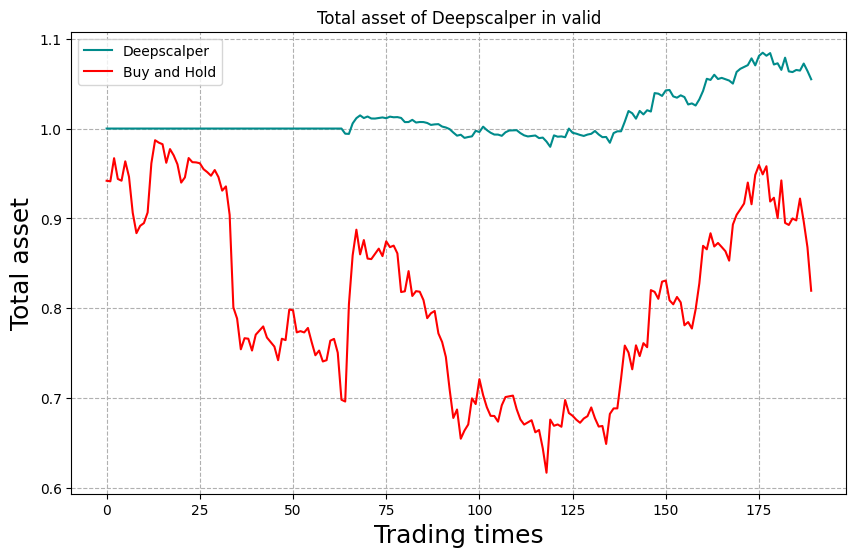

In [12]:
trainer.train_and_valid()

## Step 11: RL Agent Testing

Test Best Episode
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
|  43.612181%  |   1.032105  | 1.519806%  |  27.996425%  |
+--------------+-------------+------------+--------------+


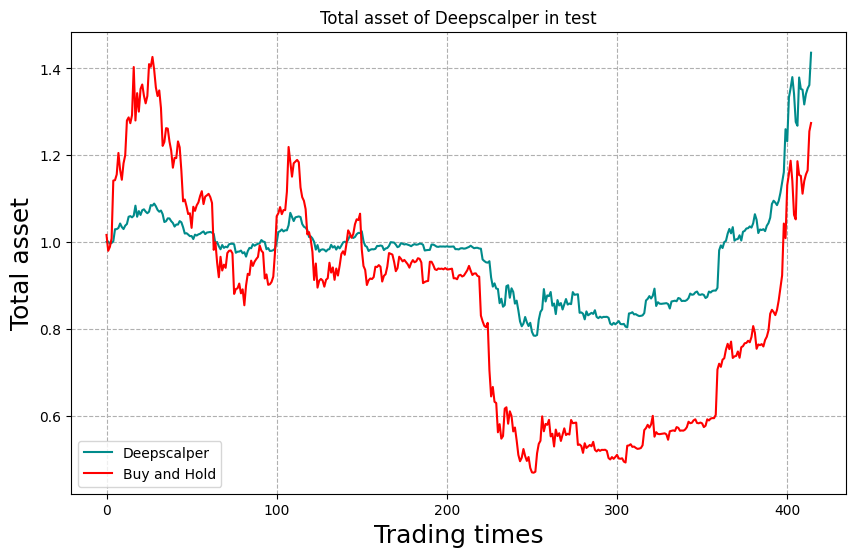

In [13]:
trainer.test();

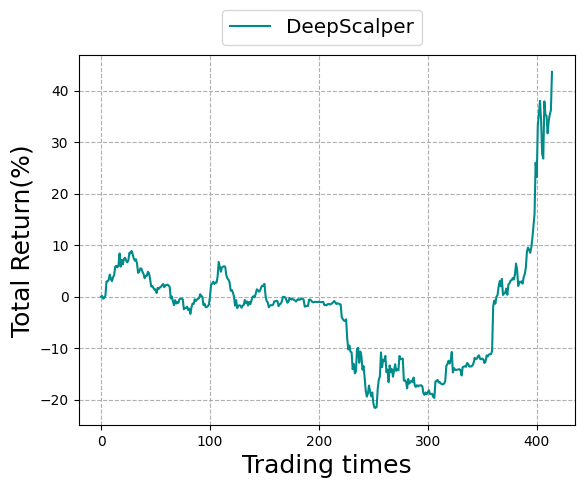

In [14]:
plot(trainer.test_environment.save_asset_memory(),alg="DeepScalper")